In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.2.0
numpy 1.16.2
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
import pprint

pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
# 分割数据集的工具
from sklearn.model_selection import train_test_split

# 分割训练集和测试集，比例为3:1
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7) 
# 分割训练集和开发集，比例是3:1，总的比例是9:3:4
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
# 标准归一化工具
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [6]:
x_train_scaled_wide = x_train_scaled[:,:5]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_test_scaled_wide = x_test_scaled[:,:5]

x_train_scaled_deep = x_train_scaled[:,-6:]
x_valid_scaled_deep = x_valid_scaled[:,-6:]
x_test_scaled_deep = x_test_scaled[:,-6:]

In [7]:
input_wide = keras.layers.Input(shape=x_train_scaled_wide.shape[1:])
input_deep = keras.layers.Input(shape=x_train_scaled_deep.shape[1:])

X = keras.layers.Dense(30,activation='relu',)(input_deep)
X = keras.layers.Dense(30,activation='relu')(X)
concat = keras.layers.concatenate([input_wide,X])
output1 = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(X)

model = keras.models.Model(inputs=[input_wide,input_deep],outputs=[output1,output2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [10]:
model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2),
             keras.callbacks.TensorBoard(log_dir='logs/wide-deep-multi-input-callbacks')]

history = model.fit([x_train_scaled_wide,x_train_scaled_deep], [y_train,y_train],
                    validation_data = ([x_valid_scaled_wide,x_valid_scaled_deep], 
                                       [y_valid,y_valid]),
                    epochs = 100,
                    callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 88us/sample - loss: 4.5754 - dense_2_loss: 2.2158 - dense_3_loss: 2.3596 - val_loss: 2.2995 - val_dense_2_loss: 0.8969 - val_dense_3_loss: 1.4027
Epoch 2/100
11610/11610 [==============================] - 1s 56us/sample - loss: 1.9268 - dense_2_loss: 0.7439 - dense_3_loss: 1.1829 - val_loss: 1.9239 - val_dense_2_loss: 0.7287 - val_dense_3_loss: 1.1952
Epoch 3/100
11610/11610 [==============================] - 1s 56us/sample - loss: 1.7037 - dense_2_loss: 0.6485 - dense_3_loss: 1.0551 - val_loss: 1.7326 - val_dense_2_loss: 0.6632 - val_dense_3_loss: 1.0693
Epoch 4/100
11610/11610 [==============================] - 1s 56us/sample - loss: 1.5424 - dense_2_loss: 0.5996 - dense_3_loss: 0.9428 - val_loss: 1.5738 - val_dense_2_loss: 0.6214 - val_dense_3_loss: 0.9524
Epoch 5/100
11610/11610 [==============================] - 1s 56us/sample - loss: 1.4156 - dense_2_loss: 0.5690 - dense

Epoch 40/100
11610/11610 [==============================] - 1s 57us/sample - loss: 0.8950 - dense_2_loss: 0.3946 - dense_3_loss: 0.5004 - val_loss: 0.9386 - val_dense_2_loss: 0.4144 - val_dense_3_loss: 0.5242
Epoch 41/100
11610/11610 [==============================] - 1s 75us/sample - loss: 0.8907 - dense_2_loss: 0.3937 - dense_3_loss: 0.4970 - val_loss: 0.9337 - val_dense_2_loss: 0.4139 - val_dense_3_loss: 0.5198
Epoch 42/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.8858 - dense_2_loss: 0.3916 - dense_3_loss: 0.4942 - val_loss: 0.9387 - val_dense_2_loss: 0.4159 - val_dense_3_loss: 0.5228
Epoch 43/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.8822 - dense_2_loss: 0.3904 - dense_3_loss: 0.4918 - val_loss: 0.9276 - val_dense_2_loss: 0.4143 - val_dense_3_loss: 0.5134
Epoch 44/100
11610/11610 [==============================] - 1s 60us/sample - loss: 0.8772 - dense_2_loss: 0.3891 - dense_3_loss: 0.4881 - val_loss: 0.9167 - val_den

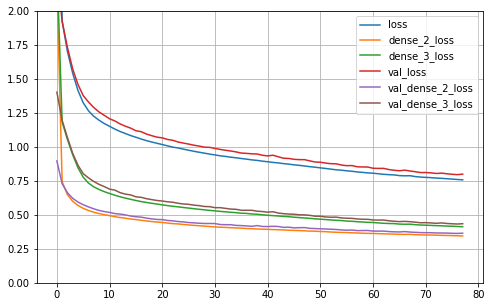

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 2)
    plt.show()
plot_learning_curves(history)

In [14]:
model.evaluate([x_test_scaled_wide,x_test_scaled_deep], [y_test,y_test])

5160/5160 [==============================] - 0s 32us/sample - loss: 0.7832 - dense_2_loss: 0.3588 - dense_3_loss: 0.4244


[0.7831862974536511, 0.35879305, 0.42439333]